# Word2Vec + LSTM

In this notebook, we implement an approach that combines Word2Vec and LSTM to tackle sentiment classification on our dataset. The rationale behind this method is to leverage the strengths of both techniques: Word2Vec for capturing semantic relationships between words by representing them in a continuous vector space, and LSTM for modeling the sequential nature and contextual dependencies within the text.

In [1]:
!pip install -q gdown gensim

In [2]:
# import
import tarfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gdown
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from gensim.models import KeyedVectors

# Load Dataset, Data Understanding and preprocessing

In this section, we download a 500k-row subset of the Amazon Review Full dataset from Google Drive. The dataset is in its raw, non-preprocessed form.

In [6]:
file_id = '1AtYLNOobU6PbvvDATGetGIeVDGYn1uQ2'
output_name = 'dataset_v2_500K_np.csv'

!gdown --id {file_id} -O {output_name}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1AtYLNOobU6PbvvDATGetGIeVDGYn1uQ2
From (redirected): https://drive.google.com/uc?id=1AtYLNOobU6PbvvDATGetGIeVDGYn1uQ2&confirm=t&uuid=ec4929f3-45ba-4cc0-9fa3-a90fe91c12c7
To: /content/dataset_v2_500K_np.csv
100% 223M/223M [00:01<00:00, 197MB/s]


In [13]:
# Set options to show full text and all rows
pd.set_option('display.max_colwidth', None)
# Read the training data into a DataFrame
df_train = pd.read_csv('dataset_v2_500K_np.csv', header=None)
df_train.columns = ['Text', 'Rating']
# Display the first few rows
df_train.head()

<ipython-input-13-55d99585b619>:4: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('dataset_v2_500K_np.csv', header=None)


,Text,Rating
0,Text,Rating
1,No Lonesome Dove Lonesome Dove is one of the best books I've ever read but Dead's Man Walk can't hold a candle to it. The Rangers are portrayed as bumbling idiots who are captured or ambushed as easily as picking up a baby. I especially didn't like the ending. I thought Call and Gus would have it out with Buffalo Hump but not to be (I won't spoil the ending). It's still a good read but it's no Lonesome Dove or Streets of Laredo (an excellent read!!). If you find it at a garage sale or thrift store for a cheap price then by all means pick it up.,3
2,"Not I was hoping for Don't expect these to be magical.I am pretty easy on tools, but these aren't that tough.On one stuck bolt, the first one I used broke without even giving up a fight. The 2nd one grabbed well, bu then it bent like a piece of licorice.I would recommend these for very light-duty work.Fortunately Amazon was amazing in the return process.",2
3,roof bag This bag held up good however it is not at all waterproof we had to dry all our clothes when we arrived atOur destination,2
4,"Suspensful Truly after reading the reviews written by previous readers about this book, i just had to read the book. I was intrigued ultimately about the premise of the story, a bengal tiger lose in north Georgia, AWESOME. Reading the first half of the story i found comparisons to that of the movie ""Jaws"", mystique, suspense, and great story telling both depicted by Warner and Speilber. The second half of the story then wandered a bit from the roots and went into a metaphorical shift to ones manhood. But i do truly wish many to read this story which i couldnt put down!!! Also Jim Grahams character in this story is truly charasmatic and geniune!! READ IT",5


After that, we perform some basic operations and checks on the DataFrame.

In [28]:
df_train['Rating'] = pd.to_numeric(df_train['Rating'], errors='coerce').astype('Int64')
df_train = df_train.drop(index=0).reset_index(drop=True)
df_train.head()

,Text,Rating
0,roof bag This bag held up good however it is not at all waterproof we had to dry all our clothes when we arrived atOur destination,2
1,"Suspensful Truly after reading the reviews written by previous readers about this book, i just had to read the book. I was intrigued ultimately about the premise of the story, a bengal tiger lose in north Georgia, AWESOME. Reading the first half of the story i found comparisons to that of the movie ""Jaws"", mystique, suspense, and great story telling both depicted by Warner and Speilber. The second half of the story then wandered a bit from the roots and went into a metaphorical shift to ones manhood. But i do truly wish many to read this story which i couldnt put down!!! Also Jim Grahams character in this story is truly charasmatic and geniune!! READ IT",5
2,"Received Broken When my son received this gift, the bowl was broken. I told him to call the company, but he hasn't done that yet, so I don't know what the resolution is.",2
3,"If you are computer literate just a little bit, do not read As you may have already noticed from the title of this review this is one of the worst techno-thrillers that one could choose for reading and you would be really annoyed of this dilettante writing with regard to the author's knowledge of cryptography and computers. Having in mind the popularity of Dan Brown as one of the best selling authors out there this book is a complete waste of time. Sorry to say. I give this book 1 out 5. Unfortunately there is no 0 star rating.",1
4,"NOT a Sequel To Iron Monkey! This is a run of the mill Hong Kong Actioner, and if you're a fan, you'll probably enjoy it, although not much. Donnie Yen is good, the action and fighting sequences are good, Yuen Wo Ping did design the fights. But the filming, editing, and overall quality are mediocre (fans expect this sort of low budget quality in most HK action films). I really believe this is Tai Seng's attempt to cash in on the popularity of Iron Monkey. Frankly, they've done a poor job, as any serious fan will detect absolutely no connection to that story and this.",2


In [29]:
# Show total null values in each column
df_train.isnull().sum()

,0
Text,0
Rating,0


In [30]:
# see the rows that contains Null values
df_train[df_train.isnull().any(axis=1)]

,Text,Rating


In [31]:
# Check how many duplicate rows exist
df_train.duplicated().sum()

0

The rating distribution is well balanced, with each class representing roughly 20% of the data. This reduces the risk of class imbalance affecting model performance.

In [32]:
df_train['Rating'].value_counts(normalize=True) * 100

,proportion
Rating,
5,20.05328
3,20.04528
1,20.02408
2,19.94528
4,19.93208


In [35]:
# Number of rows
print("Number of rows:", len(df_train))

# Check for null values
if df_train.isnull().values.any():
    print("There are null elements in the DataFrame.")
else:
    print("There are no null elements in the DataFrame.")

Number of rows: 499998
There are no null elements in the DataFrame.


To simplify the classification task, we convert the problem to binary sentiment analysis.
Ratings of 4 and 5 are labeled as positive (1), while 1 and 2 are labeled as negative (0).
Neutral reviews (rating = 3) are excluded from the dataset.

In [41]:
# Keep only positive (4,5) and negative (1,2) ratings
# throw away neutral reviews with rating = 3
df_train = df_train[df_train['Rating'] != 3].copy()

df_train['sentiment'] = df_train['Rating'].apply(lambda x: 1 if x > 3 else 0)

In [43]:
df_train['sentiment'].value_counts()

,count
sentiment,
1,199926
0,199846


In [45]:
df_train.head(10)

,Text,Rating,sentiment
0,roof bag This bag held up good however it is not at all waterproof we had to dry all our clothes when we arrived atOur destination,2,0
1,"Suspensful Truly after reading the reviews written by previous readers about this book, i just had to read the book. I was intrigued ultimately about the premise of the story, a bengal tiger lose in north Georgia, AWESOME. Reading the first half of the story i found comparisons to that of the movie ""Jaws"", mystique, suspense, and great story telling both depicted by Warner and Speilber. The second half of the story then wandered a bit from the roots and went into a metaphorical shift to ones manhood. But i do truly wish many to read this story which i couldnt put down!!! Also Jim Grahams character in this story is truly charasmatic and geniune!! READ IT",5,1
2,"Received Broken When my son received this gift, the bowl was broken. I told him to call the company, but he hasn't done that yet, so I don't know what the resolution is.",2,0
3,"If you are computer literate just a little bit, do not read As you may have already noticed from the title of this review this is one of the worst techno-thrillers that one could choose for reading and you would be really annoyed of this dilettante writing with regard to the author's knowledge of cryptography and computers. Having in mind the popularity of Dan Brown as one of the best selling authors out there this book is a complete waste of time. Sorry to say. I give this book 1 out 5. Unfortunately there is no 0 star rating.",1,0
4,"NOT a Sequel To Iron Monkey! This is a run of the mill Hong Kong Actioner, and if you're a fan, you'll probably enjoy it, although not much. Donnie Yen is good, the action and fighting sequences are good, Yuen Wo Ping did design the fights. But the filming, editing, and overall quality are mediocre (fans expect this sort of low budget quality in most HK action films). I really believe this is Tai Seng's attempt to cash in on the popularity of Iron Monkey. Frankly, they've done a poor job, as any serious fan will detect absolutely no connection to that story and this.",2,0
5,"Nice read Having read many singer bios, I came across Simionato's and decided to read it. It's an ok book but not very entertaining. It's basically more a chronology of performances and critical reviews than a real biography. A. Varnay's, C. Ludwig's and B. Nilsson's bios are far more entertaining and thorough....There's a tribute chapter that's way too long. ONLY for hardcore fans",4,1
6,"Cheaply made I bought this digital camera for a vacation and have been embarrased ever since over the cheapness in quality of this camera. The battery door falls off and the batteries run out quickly. It doesn't stay on for more than a few seconds, causing the picture taker to miss shots over and over again. I spent a good deal on the camera with a upgraded digital card and now it is rarely used because it's such a piece of junk. I won't buy another Vivitar after this one. It's worth the money to buy a better brand, like a Canon or Nikon. I have a Nikon Coolpix now and I love it! Wish I'd spent that money the first time instead of on the Vivitar.",1,0
7,"Does It Work For The PS2 OK, let me get this straight. YES, it does work for the PS2 becuase the PS1 and PS2 have the same outlet type and same electricy quantity. So, if you have a LCD screen or tv in your car, this is a must.",5,1
8,"Interesting Introduction to Philosophy While another review on this book points to the fact that it does not cover ""the classics of philosophy,"" I found it to be an interesting introduction to the discipline. This book was required reading for a Master's level philosophy course, thus I was ""forced"" to read it. But, I found it to be enlightening due to its nature.I have tried to circle through some of the ""classics"" and often have a difficult time relating them to the modern world. This book, in using modern writers, does a great job of connecting the basic pr

At this stage, we apply minimal text preprocessing: we convert all text to lowercase and remove line breaks (\n).

In [49]:
df_train['Text'] = df_train['Text'].apply(lambda text: text.lower().replace('\n', ' '))
df_train.head(10)

,Text,Rating,sentiment
0,roof bag this bag held up good however it is not at all waterproof we had to dry all our clothes when we arrived atour destination,2,0
1,"suspensful truly after reading the reviews written by previous readers about this book, i just had to read the book. i was intrigued ultimately about the premise of the story, a bengal tiger lose in north georgia, awesome. reading the first half of the story i found comparisons to that of the movie ""jaws"", mystique, suspense, and great story telling both depicted by warner and speilber. the second half of the story then wandered a bit from the roots and went into a metaphorical shift to ones manhood. but i do truly wish many to read this story which i couldnt put down!!! also jim grahams character in this story is truly charasmatic and geniune!! read it",5,1
2,"received broken when my son received this gift, the bowl was broken. i told him to call the company, but he hasn't done that yet, so i don't know what the resolution is.",2,0
3,"if you are computer literate just a little bit, do not read as you may have already noticed from the title of this review this is one of the worst techno-thrillers that one could choose for reading and you would be really annoyed of this dilettante writing with regard to the author's knowledge of cryptography and computers. having in mind the popularity of dan brown as one of the best selling authors out there this book is a complete waste of time. sorry to say. i give this book 1 out 5. unfortunately there is no 0 star rating.",1,0
4,"not a sequel to iron monkey! this is a run of the mill hong kong actioner, and if you're a fan, you'll probably enjoy it, although not much. donnie yen is good, the action and fighting sequences are good, yuen wo ping did design the fights. but the filming, editing, and overall quality are mediocre (fans expect this sort of low budget quality in most hk action films). i really believe this is tai seng's attempt to cash in on the popularity of iron monkey. frankly, they've done a poor job, as any serious fan will detect absolutely no connection to that story and this.",2,0
5,"nice read having read many singer bios, i came across simionato's and decided to read it. it's an ok book but not very entertaining. it's basically more a chronology of performances and critical reviews than a real biography. a. varnay's, c. ludwig's and b. nilsson's bios are far more entertaining and thorough....there's a tribute chapter that's way too long. only for hardcore fans",4,1
6,"cheaply made i bought this digital camera for a vacation and have been embarrased ever since over the cheapness in quality of this camera. the battery door falls off and the batteries run out quickly. it doesn't stay on for more than a few seconds, causing the picture taker to miss shots over and over again. i spent a good deal on the camera with a upgraded digital card and now it is rarely used because it's such a piece of junk. i won't buy another vivitar after this one. it's worth the money to buy a better brand, like a canon or nikon. i have a nikon coolpix now and i love it! wish i'd spent that money the first time instead of on the vivitar.",1,0
7,"does it work for the ps2 ok, let me get this straight. yes, it does work for the ps2 becuase the ps1 and ps2 have the same outlet type and same electricy quantity. so, if you have a lcd screen or tv in your car, this is a must.",5,1
8,"interesting introduction to philosophy while another review on this book points to the fact that it does not cover ""the classics of philosophy,"" i found it to be an interesting introduction to the discipline. this book was required reading for a master's level philosophy course, thus i was ""forced"" to read it. but, i found it to be enlightening due to its nature.i have tried to circle through some of the ""classics"" and often have a difficult time relating them to the modern world. this book, in using modern writers, does a great job of connecting the basic pr

## Subsample and Splin Train vs Internal Test set

We split the dataset into training and internal test sets, using an 80/20 ratio.
Stratified sampling is applied to preserve the original sentiment class distribution in both subsets.

In [51]:
X = df_train['Text']
y = df_train['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

## Tokenization

We initialize a Keras tokenizer with a vocabulary size limit of 30,000 words and an out-of-vocabulary token (<OOV>).
The tokenizer is fitted on the training set and then used to convert both the training and test texts into sequences of integer tokens.

In [52]:
# Set vocabulary size
max_words = 30000
# Initialize the tokenizer
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
# fit the tokenizer on TR set
tokenizer.fit_on_texts(X_train)
# tokenize TR set
train_sequences = tokenizer.texts_to_sequences(X_train)
# tokenize TS set
test_sequences = tokenizer.texts_to_sequences(X_test)

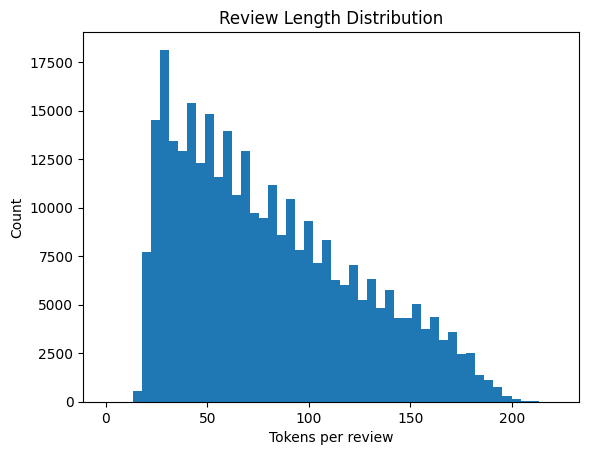

In [53]:
# analyzing review length distribution before padding
lengths = [len(seq) for seq in train_sequences]
plt.hist(lengths, bins=50)
plt.title("Review Length Distribution")
plt.xlabel("Tokens per review")
plt.ylabel("Count")
plt.show()

In [54]:
print("95th percentile length:", np.percentile(lengths, 95))

95th percentile length: 164.0


We pad all input sequences to a fixed length of 164 tokens.
Padding and truncation are applied at the beginning of the sequences ('pre') to ensure uniform input size for the model.

In [55]:
max_len = 164
# pad train seq.
train_sequences_padded = pad_sequences(train_sequences, maxlen=max_len, padding='pre', truncating='pre')
# pad test seq.
test_sequences_padded = pad_sequences(test_sequences, maxlen=max_len, padding='pre', truncating='pre')

## Word2Vec

We download the pre-trained Google News Word2Vec embeddings (300-dimensional), which will be used for the embeddings in our model. These embeddings are widely used and trained on a large corpus of news articles.

In [56]:
file_id = '1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy'
output_path = 'GoogleNews-vectors-negative300.bin'
gdown.download(f'https://drive.google.com/uc?id={file_id}', output=output_path, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy
From (redirected): https://drive.google.com/uc?id=1Sra_JrYMx7_3ENBHQRkgD0z3NfK_S8qy&confirm=t&uuid=3fe637b6-dd6b-4d8d-b68b-0a4da2a7a61e
To: /content/GoogleNews-vectors-negative300.bin
100%|██████████| 3.64G/3.64G [00:43<00:00, 83.5MB/s]


'GoogleNews-vectors-negative300.bin'

In [57]:
w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

We build the embedding matrix by assigning pre-trained Word2Vec vectors to the words in our vocabulary.
Words not found in the Word2Vec model are initialized with random values drawn from a normal distribution (mean = 0, std = 0.6).

In [58]:
embedding_dim = 300
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in tokenizer.word_index.items():
    if i < max_words:
        if word in w2v_model:
            embedding_matrix[i] = w2v_model[word]
        else:
            embedding_matrix[i] = np.random.normal(scale=0.6, size=(embedding_dim,))


## Model Definition

We define a simple neural network architecture consisting of:
- a frozen embedding layer initialized with pre-trained Word2Vec vectors,
- an LSTM layer with 128 units to capture sequential patterns,
- and a final dense layer with sigmoid activation for binary classification.

The model is compiled with binary crossentropy loss and the Adam optimizer.

In [59]:
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(128),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


The training accuracy steadily increases across epochs, reaching 94.3%, while the validation accuracy stabilizes around 92.7%, suggesting good generalization without significant overfitting.

After training, we evaluate the model on the test set using standard classification metrics:

- Precision, Recall, and F1-score are all around 0.93 for both sentiment classes (positive and negative).
- The overall accuracy is 93% on a test set of nearly 80,000 samples.
- The confusion matrix shows a balanced performance, with slightly more false positives (~3200) than false negatives (~2500), but no severe class imbalance or skew.

In [60]:
model.fit(train_sequences_padded, y_train, epochs=5,
          validation_split=0.2, batch_size=64)

Epoch 1/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 41s 9ms/step - accuracy: 0.7682 - loss: 0.4751 - val_accuracy: 0.8949 - val_loss: 0.2644
Epoch 2/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - accuracy: 0.9029 - loss: 0.2398 - val_accuracy: 0.9152 - val_loss: 0.2131
Epoch 3/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.9225 - loss: 0.1962 - val_accuracy: 0.9169 - val_loss: 0.2127
Epoch 4/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.9326 - loss: 0.1751 - val_accuracy: 0.9270 - val_loss: 0.1910
Epoch 5/5
3998/3998 ━━━━━━━━━━━━━━━━━━━━ 37s 9ms/step - accuracy: 0.9432 - loss: 0.1517 - val_accuracy: 0.9272 - val_loss: 0.1892


In [61]:
y_pred_prob = model.predict(test_sequences_padded)
y_pred_class = (y_pred_prob > 0.5).astype(int)

print("Classification Report:")
print(classification_report(y_test, y_pred_class))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_class))

2499/2499 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93     39969
           1       0.92      0.94      0.93     39986

    accuracy                           0.93     79955
   macro avg       0.93      0.93      0.93     79955
weighted avg       0.93      0.93      0.93     79955

Confusion Matrix:
[[36756  3213]
 [ 2549 37437]]


The Word2Vec + LSTM model achieves high accuracy and balanced precision/recall, making it effective for binary sentiment classification.
Further improvements could include tuning hyperparameters, using a trainable embedding layer, or incorporating additional text preprocessing